In [2]:
from gene.optimisers.crossing import CrossingOptimiser
import random

import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
from tqdm import tqdm

from gene.optimisers.annealing import AnnealingOptimiser
import torch

from gene.targets import get_negative_accuracy_target
from gene.util import get_accuracy, grid_search


random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

DEVICE = ["cpu", "cuda"][1]
N_EPOCHS = 5


def train(max_couples=0.999, init_std=5):
    # Define the model
    model = torch.nn.Sequential(
        torch.nn.Flatten(),
        torch.nn.Linear(28*28, 256),
        torch.nn.ReLU(),
        torch.nn.Linear(256, 64),
        torch.nn.ReLU(),
        torch.nn.Linear(64, 10)
    )
    models = [model.to(DEVICE)]

    # Define the optimiser
    optimiser = CrossingOptimiser(target_func=get_negative_accuracy_target,
                                  random_function=lambda shape: torch.normal(0, init_std, shape),
                                  selection_limit=10,
                                  max_couples=max_couples,
                                  n_children_per_couple=2,
                                  device=DEVICE)

    # Define the data
    train_data = datasets.MNIST(
            root="./cache",
            download=True,
            train=True,
            transform=transforms.ToTensor()
    )
    train_loader = DataLoader(train_data, batch_size=1024, shuffle=True)
    test_data = datasets.MNIST(
            root="./cache",
            download=True,
            train=False,
            transform=transforms.ToTensor()
        )
    test_loader = DataLoader(test_data, batch_size=1024)

    for e in tqdm(range(N_EPOCHS)):
        for images, labels in train_loader:
            models = optimiser.step(models, images.to(DEVICE), labels.to(DEVICE))

    return np.mean([get_accuracy(test_loader, m, DEVICE) for m in models])


parameters = {"max_couples": np.linspace(10, 20, 4).astype(int),
              "init_std": np.logspace(np.log10(0.01), np.log10(20), 10)}
n_param_0, n_param_1 = len(list(parameters.values())[0]), len(list(parameters.values())[1])
results = grid_search(trainer=train, parameters=parameters)
print(results)

  0%|          | 0/40 [00:00<?, ?it/s]

{'max_couples': 10, 'init_std': 0.01}



  2%|▎         | 1/40 [00:43<28:35, 43.98s/it]

{'max_couples': 10, 'init_std': 0.02326918168776363}



  5%|▌         | 2/40 [01:23<26:22, 41.65s/it]

{'max_couples': 10, 'init_std': 0.05414548164181543}



  8%|▊         | 3/40 [02:03<25:06, 40.71s/it]

{'max_couples': 10, 'init_std': 0.12599210498948735}



 10%|█         | 4/40 [02:43<24:19, 40.54s/it]

{'max_couples': 10, 'init_std': 0.29317331822241716}



 12%|█▎        | 5/40 [03:23<23:24, 40.13s/it]

{'max_couples': 10, 'init_std': 0.6821903207721969}



 15%|█▌        | 6/40 [04:03<22:40, 40.00s/it]

{'max_couples': 10, 'init_std': 1.5874010519682002}



 18%|█▊        | 7/40 [04:42<21:55, 39.85s/it]

{'max_couples': 10, 'init_std': 3.6937523489595185}



 20%|██        | 8/40 [05:22<21:15, 39.85s/it]

{'max_couples': 10, 'init_std': 8.595059451754269}



 22%|██▎       | 9/40 [06:01<20:29, 39.67s/it]

{'max_couples': 10, 'init_std': 20.000000000000004}



 25%|██▌       | 10/40 [06:41<19:49, 39.64s/it]

{'max_couples': 13, 'init_std': 0.01}



 28%|██▊       | 11/40 [07:25<19:53, 41.14s/it]

{'max_couples': 13, 'init_std': 0.02326918168776363}



 30%|███       | 12/40 [08:10<19:40, 42.17s/it]

{'max_couples': 13, 'init_std': 0.05414548164181543}



 32%|███▎      | 13/40 [08:57<19:37, 43.63s/it]

{'max_couples': 13, 'init_std': 0.12599210498948735}



 35%|███▌      | 14/40 [09:42<19:03, 43.98s/it]

{'max_couples': 13, 'init_std': 0.29317331822241716}



 38%|███▊      | 15/40 [10:26<18:25, 44.23s/it]

{'max_couples': 13, 'init_std': 0.6821903207721969}



 40%|████      | 16/40 [11:11<17:42, 44.29s/it]

{'max_couples': 13, 'init_std': 1.5874010519682002}



 42%|████▎     | 17/40 [11:55<16:59, 44.34s/it]

{'max_couples': 13, 'init_std': 3.6937523489595185}



 45%|████▌     | 18/40 [12:40<16:16, 44.40s/it]

{'max_couples': 13, 'init_std': 8.595059451754269}



 48%|████▊     | 19/40 [13:25<15:35, 44.54s/it]

{'max_couples': 13, 'init_std': 20.000000000000004}



 50%|█████     | 20/40 [14:10<14:52, 44.64s/it]

{'max_couples': 16, 'init_std': 0.01}



 52%|█████▎    | 21/40 [14:59<14:37, 46.17s/it]

{'max_couples': 16, 'init_std': 0.02326918168776363}



 55%|█████▌    | 22/40 [15:49<14:09, 47.18s/it]

{'max_couples': 16, 'init_std': 0.05414548164181543}



 57%|█████▊    | 23/40 [16:38<13:34, 47.91s/it]

{'max_couples': 16, 'init_std': 0.12599210498948735}



 60%|██████    | 24/40 [17:28<12:55, 48.44s/it]

{'max_couples': 16, 'init_std': 0.29317331822241716}



 62%|██████▎   | 25/40 [18:17<12:07, 48.50s/it]

{'max_couples': 16, 'init_std': 0.6821903207721969}



 65%|██████▌   | 26/40 [19:07<11:24, 48.87s/it]

{'max_couples': 16, 'init_std': 1.5874010519682002}



 68%|██████▊   | 27/40 [19:56<10:38, 49.12s/it]

{'max_couples': 16, 'init_std': 3.6937523489595185}



 70%|███████   | 28/40 [20:46<09:53, 49.45s/it]

{'max_couples': 16, 'init_std': 8.595059451754269}



 72%|███████▎  | 29/40 [21:38<09:10, 50.03s/it]

{'max_couples': 16, 'init_std': 20.000000000000004}



 75%|███████▌  | 30/40 [22:27<08:18, 49.88s/it]

{'max_couples': 20, 'init_std': 0.01}



 78%|███████▊  | 31/40 [23:23<07:45, 51.71s/it]

{'max_couples': 20, 'init_std': 0.02326918168776363}



 80%|████████  | 32/40 [24:20<07:06, 53.33s/it]

{'max_couples': 20, 'init_std': 0.05414548164181543}



 82%|████████▎ | 33/40 [25:17<06:20, 54.39s/it]

{'max_couples': 20, 'init_std': 0.12599210498948735}



 85%|████████▌ | 34/40 [26:15<05:31, 55.25s/it]

{'max_couples': 20, 'init_std': 0.29317331822241716}



 88%|████████▊ | 35/40 [27:11<04:38, 55.75s/it]

{'max_couples': 20, 'init_std': 0.6821903207721969}



 90%|█████████ | 36/40 [28:09<03:44, 56.17s/it]

{'max_couples': 20, 'init_std': 1.5874010519682002}



 92%|█████████▎| 37/40 [29:05<02:48, 56.19s/it]

{'max_couples': 20, 'init_std': 3.6937523489595185}



 95%|█████████▌| 38/40 [30:01<01:52, 56.11s/it]

{'max_couples': 20, 'init_std': 8.595059451754269}



 98%|█████████▊| 39/40 [30:57<00:56, 56.10s/it]

{'max_couples': 20, 'init_std': 20.000000000000004}



100%|██████████| 40/40 [31:53<00:00, 47.84s/it]

[Result(max_couples=10, init_std=0.01, score=0.48858999999999997), Result(max_couples=10, init_std=0.02326918168776363, score=0.53643), Result(max_couples=10, init_std=0.05414548164181543, score=0.45514), Result(max_couples=10, init_std=0.12599210498948735, score=0.5419700000000001), Result(max_couples=10, init_std=0.29317331822241716, score=0.47165), Result(max_couples=10, init_std=0.6821903207721969, score=0.5265299999999999), Result(max_couples=10, init_std=1.5874010519682002, score=0.5014000000000001), Result(max_couples=10, init_std=3.6937523489595185, score=0.4709999999999999), Result(max_couples=10, init_std=8.595059451754269, score=0.54206), Result(max_couples=10, init_std=20.000000000000004, score=0.48665), Result(max_couples=13, init_std=0.01, score=0.51703), Result(max_couples=13, init_std=0.02326918168776363, score=0.5421199999999999), Result(max_couples=13, init_std=0.05414548164181543, score=0.49107), Result(max_couples=13, init_std=0.12599210498948735, score=0.5061099999

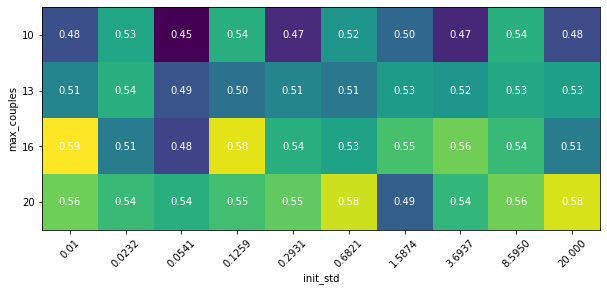

In [3]:
scores = [result.score for result in results]
scores = np.reshape(scores, (n_param_0, n_param_1))

fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(scores)

for i in range(n_param_0):
    for j in range(n_param_1):
        text = ax.text(j, i, str(scores[i, j])[:4],
                       ha="center", va="center", color="w")
ax.set_xticks(range(n_param_1))
ax.set_xticklabels([str(val)[:6] for val in list(parameters.values())[1]])
ax.set_yticks(range(n_param_0))
ax.set_yticklabels([str(val)[:6] for val in list(parameters.values())[0]])
ax.set_xlabel(list(parameters.keys())[1])
ax.set_ylabel(list(parameters.keys())[0])
plt.xticks(rotation=45)

plt.show()